In [ ]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [23]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.local.FastSCNN.models import fast_scnn
from metrics_and_losses import metrics
from utils import segmentation_labels, custom_transforms
import matplotlib.pyplot as plt
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [25]:
# === defining transforms ===

tH, tW = 256, 256
diameter = 7
sigma_color = 50
sigma_space = 100
horizontal_flip = custom_transforms.PartiallyDeterministicHorizontalFlip(p=0.5)
center_crop = custom_transforms.PartiallyDeterministicCenterCrop(p=0.5)

image_transform = T.Compose([
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])

target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
X_train, _, Y_train, _ = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)

# setting up hyperparameters for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
batch_size = 32
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU
learning_rate = 0.01

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.49856587284990184, average_train_score: 0.3838539719581604
average_val_loss: 0.5089450927953871, average_val_score: 0.3816889524459839
--- Epoch 2/10 ---
average_train_loss: 0.2989398977185926, average_train_score: 0.47119635343551636
average_val_loss: 0.3289791033381507, average_val_score: 0.4827796220779419
--- Epoch 3/10 ---
average_train_loss: 0.23566678459318274, average_train_score: 0.523853063583374
average_val_loss: 0.22152200175656211, average_val_score: 0.5369290113449097
--- Epoch 4/10 ---
average_train_loss: 0.19776669522466142, average_train_score: 0.558746337890625
average_val_loss: 0.21950111289819083, average_val_score: 0.5637363195419312
--- Epoch 5/10 ---
average_train_loss: 0.17373641750157048, average_train_score: 0.5798043012619019
average_val_loss: 0.20230360163582695, average_val_score: 0.5768063068389893
--- Epoch 6/10 ---
average_train_loss: 0.15426227925849437, average_train_score: 0.6022685170173645
avera

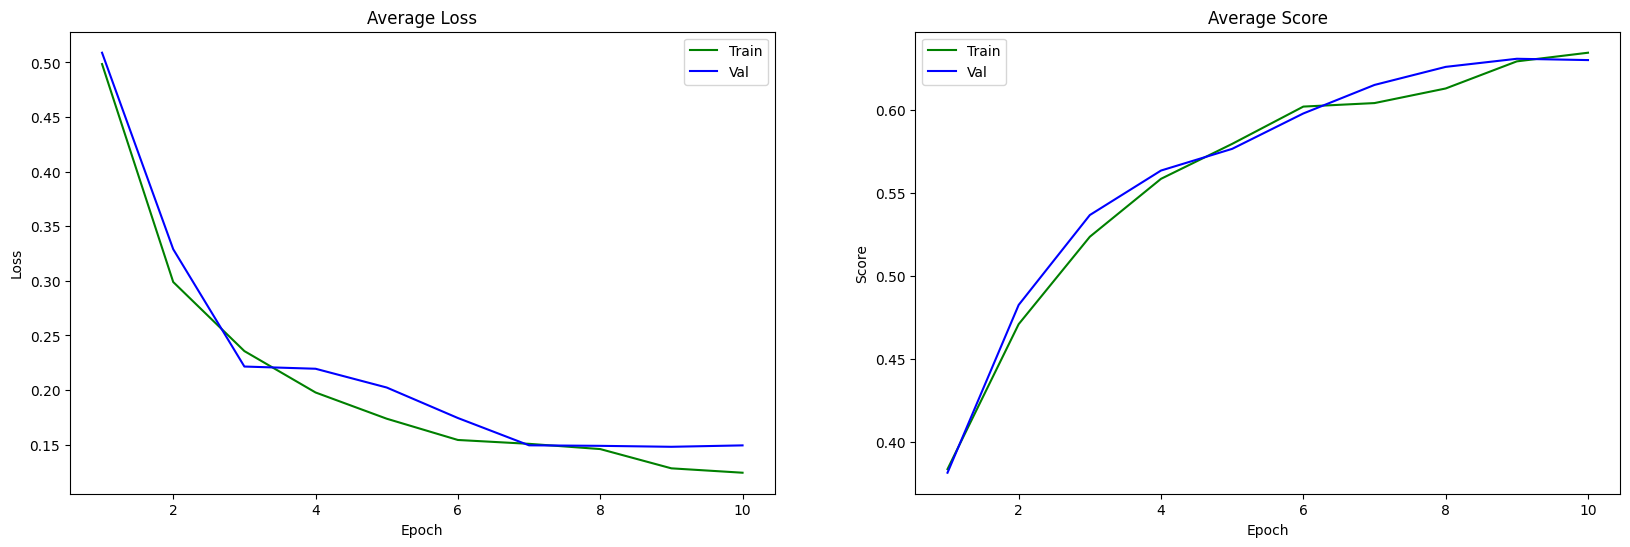

In [8]:
# === training without augmentation ===

model = fast_scnn.FastSCNN(n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.521590781432611, average_train_score: 0.38349518179893494
average_val_loss: 0.45312552461548455, average_val_score: 0.41615474224090576
--- Epoch 2/10 ---
average_train_loss: 0.31116607878622504, average_train_score: 0.4661344885826111
average_val_loss: 0.3059118997956079, average_val_score: 0.5065386295318604
--- Epoch 3/10 ---
average_train_loss: 0.24329538507509096, average_train_score: 0.5189880728721619
average_val_loss: 0.2797577319637177, average_val_score: 0.521791934967041
--- Epoch 4/10 ---
average_train_loss: 0.2064618803242333, average_train_score: 0.550163984298706
average_val_loss: 0.25435606402064126, average_val_score: 0.5416845083236694
--- Epoch 5/10 ---
average_train_loss: 0.17585903811573642, average_train_score: 0.5784024596214294
average_val_loss: 0.1730523141367095, average_val_score: 0.5890200734138489
--- Epoch 6/10 ---
average_train_loss: 0.16566760339203723, average_train_score: 0.5902233719825745
average

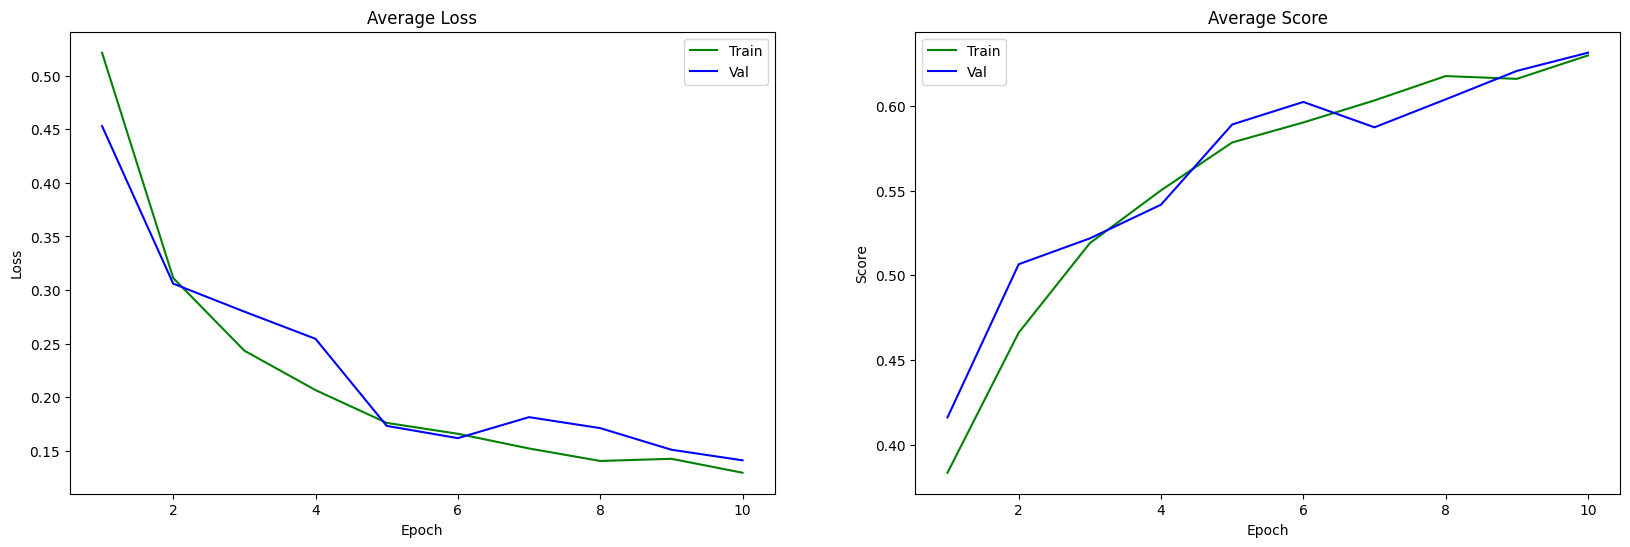

In [9]:
# === training with augmentation: ColorJitter ===

image_transform_with_augmentation = T.Compose([
    T.ColorJitter(brightness=0.25, contrast=0.25), 
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])

train_dataset_with_augmentation = dataset.MyDataset(
    X_train, Y_train, image_transform_with_augmentation, target_transform)
    
model = fast_scnn.FastSCNN(n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset_with_augmentation, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.536654014448155, average_train_score: 0.377621591091156
average_val_loss: 0.616346656330048, average_val_score: 0.34327805042266846
--- Epoch 2/10 ---
average_train_loss: 0.3178221023405379, average_train_score: 0.46406492590904236
average_val_loss: 0.29689549193495796, average_val_score: 0.49978312849998474
--- Epoch 3/10 ---
average_train_loss: 0.24166235658857557, average_train_score: 0.5242907404899597
average_val_loss: 0.2389955021559246, average_val_score: 0.5219691395759583
--- Epoch 4/10 ---
average_train_loss: 0.21385553005838667, average_train_score: 0.5502127408981323
average_val_loss: 0.2111192284122346, average_val_score: 0.553741991519928
--- Epoch 5/10 ---
average_train_loss: 0.18868070876921003, average_train_score: 0.57204669713974
average_val_loss: 0.1793685480952263, average_val_score: 0.5831982493400574
--- Epoch 6/10 ---
average_train_loss: 0.17397012247404142, average_train_score: 0.5872993469238281
average_va

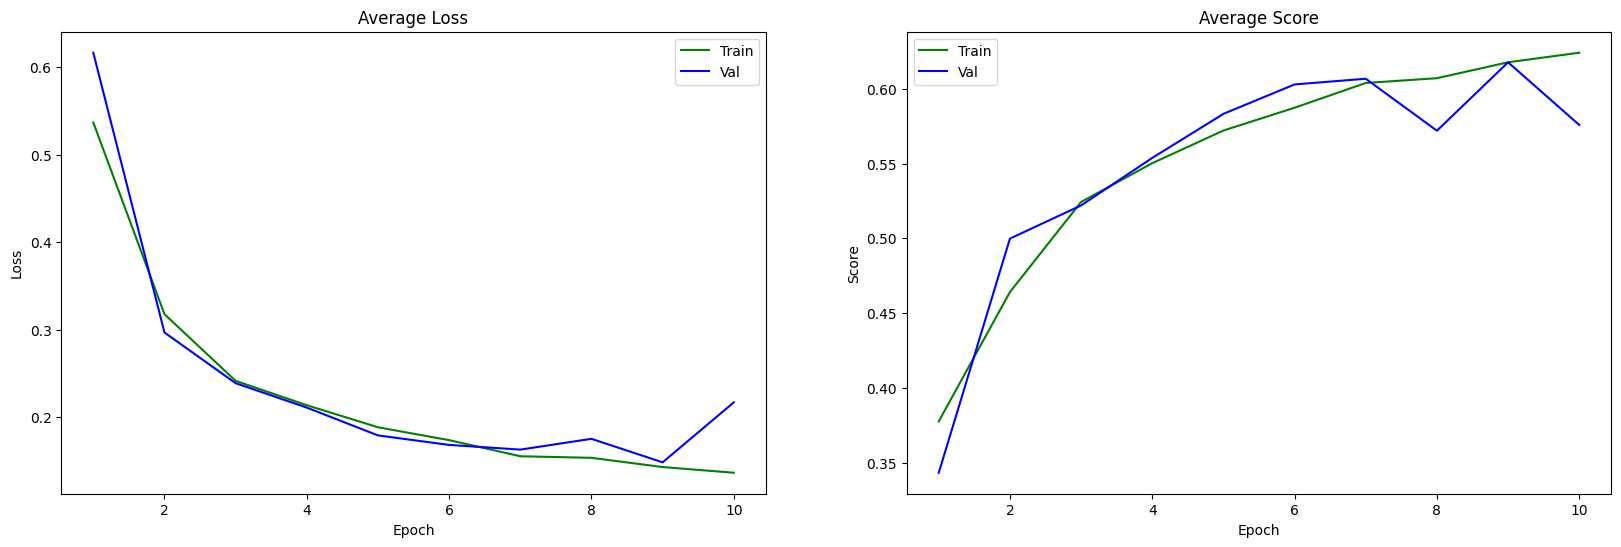

In [26]:
# === training with augmentation: horizontal_flip ===

image_transform_with_augmentation = T.Compose([
    horizontal_flip,
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])

target_transform_with_augmentation = T.Compose([
    horizontal_flip,
    T.Resize((tH, tW))])

train_dataset_with_augmentation = dataset.MyDataset(
    X_train, Y_train, image_transform_with_augmentation, target_transform_with_augmentation)
    
model = fast_scnn.FastSCNN(n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset_with_augmentation, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))

Device: cuda.
--- Epoch 1/10 ---
average_train_loss: 0.5194092384430757, average_train_score: 0.3878830373287201
average_val_loss: 0.39041359746266924, average_val_score: 0.39748942852020264
--- Epoch 2/10 ---
average_train_loss: 0.3142111304393861, average_train_score: 0.46727854013442993
average_val_loss: 0.27228515938160913, average_val_score: 0.5177661776542664
--- Epoch 3/10 ---
average_train_loss: 0.24366142840636762, average_train_score: 0.5225927233695984
average_val_loss: 0.222277233524928, average_val_score: 0.5544705986976624
--- Epoch 4/10 ---
average_train_loss: 0.20262512628339294, average_train_score: 0.5596628785133362
average_val_loss: 0.18801437010840763, average_val_score: 0.5788058638572693
--- Epoch 5/10 ---
average_train_loss: 0.17979953730972403, average_train_score: 0.5817164182662964
average_val_loss: 0.17490860476853357, average_val_score: 0.593477189540863
--- Epoch 6/10 ---
average_train_loss: 0.17289785374263753, average_train_score: 0.5916401743888855
aver

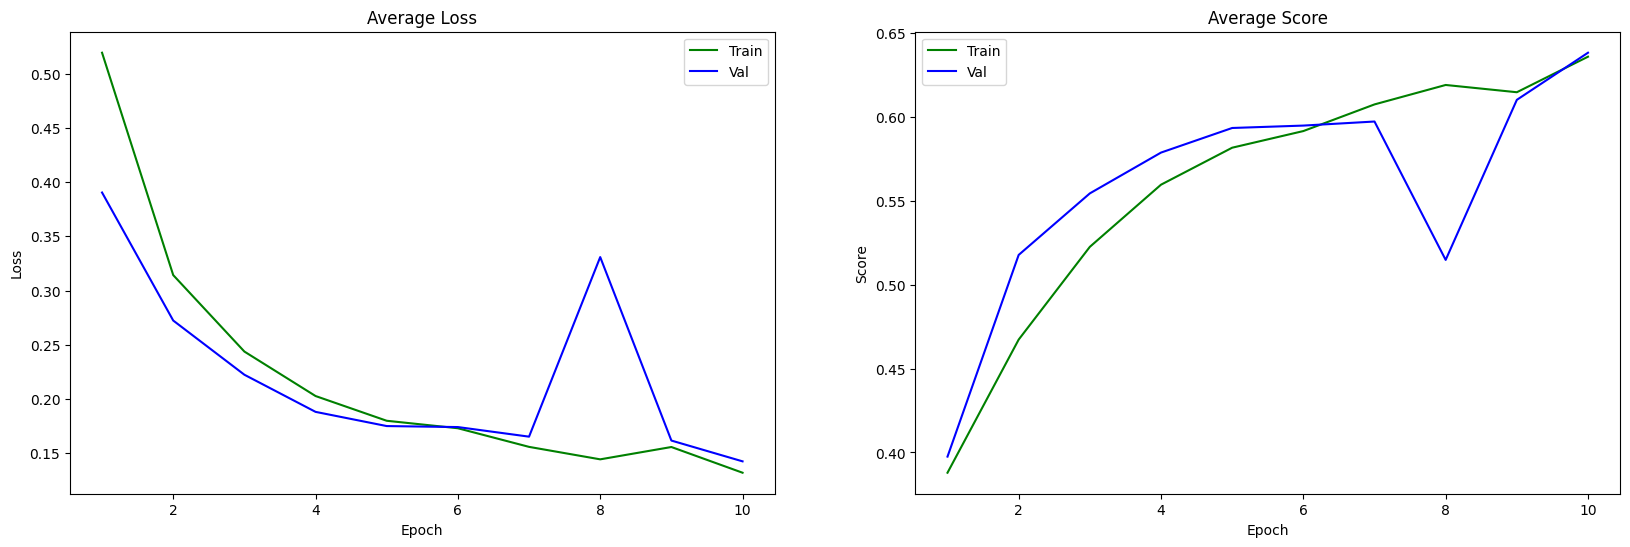

In [27]:
# === training with augmentation: center_crop ===

image_transform_with_augmentation = T.Compose([
    center_crop,
    T.Resize((tH, tW)), 
    custom_transforms.BilateralFilter(sigma_color, sigma_space, diameter), 
    T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])

target_transform_with_augmentation = T.Compose([
    center_crop,
    T.Resize((tH, tW))])

train_dataset_with_augmentation = dataset.MyDataset(
    X_train, Y_train, image_transform_with_augmentation, target_transform_with_augmentation)

model = fast_scnn.FastSCNN(n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

results = training_and_testing.train_model(
    device, model, train_dataset_with_augmentation, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

training_and_testing.plot_training_results(results, plotsize=(20, 6))